# Exercise 6: Model Interpretation 

We have evaluated our model and have a sense of how well it performing. However, we could not interpret whether the preictions are reasonable and how the model arrives at these predictions. In this exercise, we will focus on the interpretation of random forest model. There are two interpretation methods which will be demonstrated: first we look at a single decision tree and see how it makes a prediction. Later, we can look at the importance of our clinical variables from model's view. 

To simplize the problem, we will be using the first 7 variables in the dataset and set max_depth of model to 3 to interpret them.

In [139]:
# Perform previous operations 
from sklearn.model_selection import train_test_split
import pandas as pd
data = pd.read_csv("./imputed_data.csv", index_col=0)
features = data.iloc[:, 3:10]
features = pd.get_dummies(features)
feature_list = list(features.columns)
features = features.values
labels = data.mort_icu.values
label_list = ['0', '1']
train_features, test_features, train_labels, test_labels = \
                                    train_test_split(features, labels, test_size = 0.25, random_state = 2018)

In [133]:
label_list

['0', '1']

In [134]:
# Display what are the features to interpret 
feature_list

['age',
 'aniongap_min',
 'aniongap_max',
 'albumin_min',
 'albumin_max',
 'gender_F',
 'gender_M',
 'first_careunit_CCU',
 'first_careunit_CSRU',
 'first_careunit_MICU',
 'first_careunit_NICU',
 'first_careunit_SICU',
 'first_careunit_TSICU']

In [113]:
# Define a random forest model 
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=1000, max_depth=3)

In [114]:
# Fit the model
rf_model.fit(train_features, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [116]:
# Pull out one tree from the forest
tree = rf_model.estimators_[10]

In [117]:
# Import the packages to use for intepretation 
from sklearn.tree import export_graphviz
import pydot

In [118]:
# Pull out one tree from the forest
tree = rf_model.estimators_[10]

In [135]:
# Export the tree structore into dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, class_names=label_list, rounded = True, precision = 1)

In [136]:
# Convert the dot to png image 
(graph, ) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')

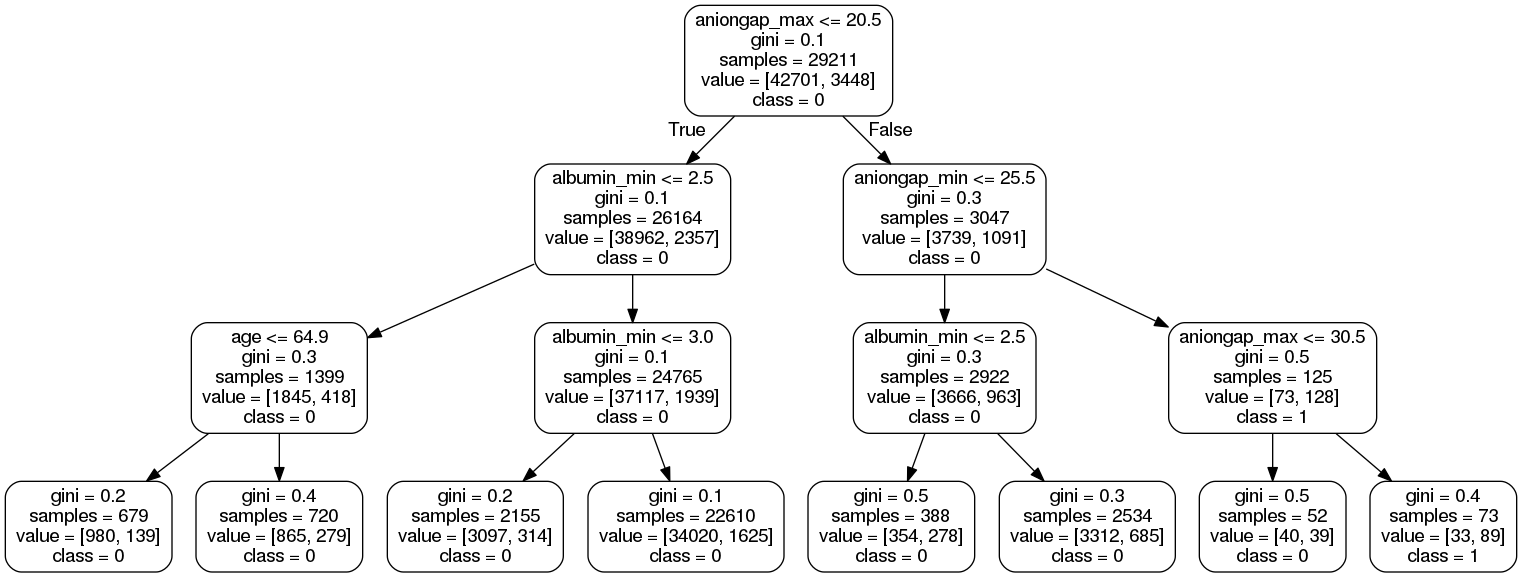

In [137]:
# Display the image
from IPython.display import Image
Image(filename = 'tree.png')

The above figure demonstrated how the model makes decision for one decision tree in the random forest. We take a patient with subject_id=3 as an example. The patient has the first-day data of: gender='M', age=76.53, first_careunit='MICU', aniongap_min=15.0, aniongap_max=23.0, albumin_min=1.8 and albumin_max=1.8. Starting from the root node, for question 'aniongap_max<=20.5', the answer is False for the example patient, so we moe to the right side of the tree. For the next level question 'aniongap_min <= 25.5', the answer is True, so we move to the left side of the node. In the next level, the answer for 'albumin_min<=2.5' is True, so we move to the left side of this node. Therefore, we conclude that for this patient, he is not likely to be dead in the ICU according to his first day conditions. We refer this back to the label in the data and we can find that this prediction is true for this patient. 

In [140]:
data.head(1)

,subject_id,hadm_id,icustay_id,gender,age,first_careunit,aniongap_min,aniongap_max,albumin_min,albumin_max,...,pt_min,pt_max,sodium_min,sodium_max,bun_min,bun_max,wbc_min,wbc_max,vent,mort_icu
0,3,145834,211552,M,76.5268,MICU,15.0,23.0,1.8,1.8,...,13.5,15.7,136.0,153.0,41.0,53.0,11.3,24.4,1,0


# Feature importance 

To quantify the importance of all variables in the random forest, we will look at the relative importance of the clinical variables. As defined by the scikit-learn package, the importances represent "if including this variable, how much it improves the prediction".

The following codes perform some tricks in Python language, including list comprehensive, zip, sorting and argument unpacking. These tricks are not the focus of these exercises, but if you want to be skilled at Python, these are the tools you should be practising.

In [145]:
# Return the importance of the model
importances = list(rf_model.feature_importances_)

# Dictionaries with variable and importance
feature_importances = {feature:round(importance, 2) for feature, importance in zip(feature_list, importances)}

# Sort the feature importances in decreasing order
feature_importances = sorted(feature_importances.items(), key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: aniongap_max         Importance: 0.29
Variable: aniongap_min         Importance: 0.22
Variable: albumin_min          Importance: 0.19
Variable: albumin_max          Importance: 0.13
Variable: age                  Importance: 0.09
Variable: first_careunit_NICU  Importance: 0.04
Variable: first_careunit_CSRU  Importance: 0.01
Variable: first_careunit_MICU  Importance: 0.01
Variable: gender_F             Importance: 0.0
Variable: gender_M             Importance: 0.0
Variable: first_careunit_CCU   Importance: 0.0
Variable: first_careunit_SICU  Importance: 0.0
Variable: first_careunit_TSICU Importance: 0.0


In [150]:
# Import matplotlib for visualization purpose
import matplotlib.pyplot as plt
%matplotlib inline 
# Set plot style
plt.style.use('fivethirtyeight')

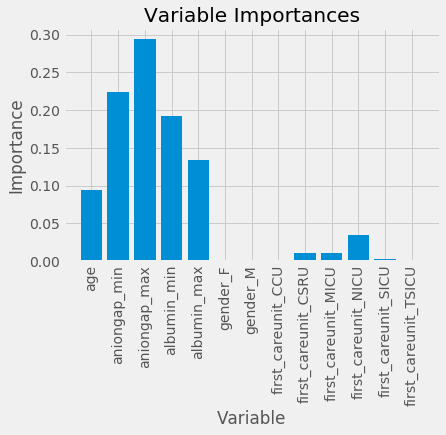

In [151]:
# the x axis for the plot 
x_axis = [i for i in range(len(importances))]

# Creat a bar plot 
plt.bar(x_axis, importances, orientation = 'vertical')
# Define xtick labels 
plt.xticks(x_axis, feature_list, rotation='vertical')
# Define axis labels and titles
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

# Limitations

Although there are interpretation methods above, there still are limitations for both random forest and SVM methods: 

- Random forest: The tree visualization is based on one of the decision trees. As mentioned, a random forest model contains a number of decision trees and averages the outputs of each decision tree. Therefore, different decision trees may have different structure but we could not visualize all of the trained decision trees. 

- SVM: In SVM, we use a kernel function to map the input features to another dimension and train a linear hyper-plane to separate between different classes (explained in background). Therefore, for a high dimension input (>3), it is impossible for us to plot and visualize them in a human understandable way